# Feature Engineering

## Review

1. Aquire
2. Prep
3. Split
4. Scale
5. Explore
6. Evaluation

## Feature Engineering

1. Construct new features: Use domain knowledge, creating products of features, etc. 
1. Use recursive feature elimination to recursively remove attributes to meet the number of required features and then builds a model on those attributes that remain to see if you can you match or improve performance with a smaller subset.   
1. Use backward elimination to recursively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.
1. Forward selection begins with an empty equation. Predictors are added one at a time beginning with the predictor with the highest correlation with the dependent variable. Variables of greater theoretical importance are entered first. Once in the equation, the variable remains there.
1. Compare several of these feature selection methods. Select the best approach with model selection.
1. To improve performance and/or understanding, subsample your data and redo your analysis for several samples.


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# import env
# import wrangle
import split_scale

# acquire data and remove null values 
# df = wrangle.wrangle_grades()

df = pd.read_csv('student_grades.csv')


### Acquire

### Prep

In [2]:
df = df.replace(r'^\s+$', np.nan, regex=True)
df.dropna(inplace=True)


In [3]:
df = df.astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 103
Data columns (total 5 columns):
student_id     102 non-null int64
exam1          102 non-null int64
exam2          102 non-null int64
exam3          102 non-null int64
final_grade    102 non-null int64
dtypes: int64(5)
memory usage: 4.8 KB


### Split

### Explore

1. are my independent variables independent of each other? (ideal)
2. is my dependent variable dependent on the independent variables? (ideal)
3. what are the drivers of my target variable? (could be some/all independent variables and/or other features not already identified)

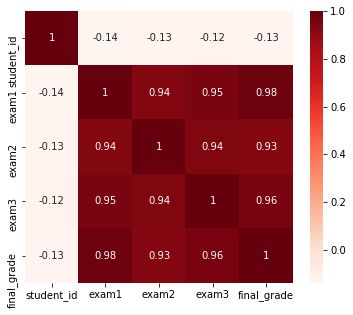

In [4]:
plt.figure(figsize=(6,5))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

#### Takeaway
- keep exam 1
- add new feature that captures the deltas from exam to exam

### Construct new features

In [5]:
df['exam_1to2'] = df['exam1'] - df['exam2']
df['exam_1to3'] = df['exam1'] - df['exam3']
df['exam_2to3'] = df['exam2'] - df['exam3']

df.drop(columns=['student_id', 'exam2', 'exam3'], inplace=True)

In [6]:
df.describe()

,exam1,final_grade,exam_1to2,exam_1to3,exam_2to3
count,102.000000,102.000000,102.000000,102.000000,102.000000
mean,78.705882,81.852941,1.205882,-5.558824,-6.764706
std,14.305429,10.953002,5.925842,6.551507,3.629299
min,57.000000,65.000000,-8.000000,-18.000000,-15.000000
25%,70.000000,72.000000,-5.000000,-8.000000,-9.000000
50%,79.000000,81.000000,3.000000,-3.000000,-5.000000
75%,92.000000,93.000000,5.000000,-2.000000,-5.000000
max,100.000000,97.000000,10.000000,5.000000,-3.000000


#### Split

In [7]:
# split into train and test
train, test = split_scale.split_my_data(df)

### Scale

In [8]:
df.dtypes

exam1          int64
final_grade    int64
exam_1to2      int64
exam_1to3      int64
exam_2to3      int64
dtype: object

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(train)
scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])

In [10]:
scaled.describe()

,exam1,final_grade,exam_1to2,exam_1to3,exam_2to3
count,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.464829,0.488812,0.477366,0.508320,0.674897
std,0.314244,0.328322,0.315345,0.274950,0.301502
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.302326,0.218750,0.166667,0.434783,0.500000
50%,0.511628,0.500000,0.611111,0.652174,0.833333
75%,0.651163,0.687500,0.611111,0.695652,0.833333
max,1.000000,1.000000,1.000000,1.000000,1.000000


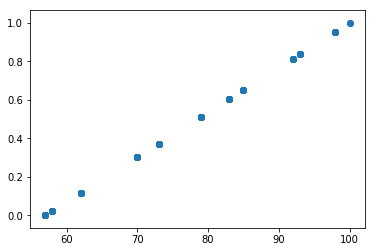

In [11]:
plt.scatter(train.exam1, scaled.exam1)

### correlation threshold

### Select K-Best
SelectKBest removes all but the highest scoring features
Scores are the test statistic for the chosen function or test (Chi-squared, F-regression, etc.)


In [12]:
from sklearn.feature_selection import SelectKBest, f_regression
X_train = scaled.drop(columns=['final_grade'])
y_train = scaled[['final_grade']]

f_selector = SelectKBest(f_regression, k=3).fit(X_train, y_train)

f_support = f_selector.get_support()
print(f_support)
print(X_train.loc[:,f_support].columns.tolist())

f_selector.scores_

[ True  True  True False]
['exam1', 'exam_1to2', 'exam_1to3']


array([2480.06685901,   93.12086279,  196.23278584,    9.13171426])

### Wrapper Methods

In [14]:
# backward elimination with OLS
import statsmodels.api as sm

In [22]:
cols = list(X_train.columns)
pmax = 1

while (len(cols) > 0):
    p = []
    x_1 = X_train[cols]
#     x_1 = sm.add_constant(x_1)
    model = sm.OLS(y_train, x_1).fit()
    p = pd.Series(model.pvalues.values[0:,],index=cols)
    pmax = max(p)
    feature_with_pmax = p.idxmax()
    #  = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_pmax)
    else:
        break
        

In [24]:
cols

['exam1', 'exam_1to2', 'exam_1to3', 'exam_2to3']